In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pymongo import MongoClient
import urllib.parse
import matplotlib.pyplot as plt
from PIL import Image

import os
import sys
import json
from json import dumps

# From within the docker-compose application, use "mongodb_container", for local development use "localhost"
#dbServer = os.getenv("MONGO_DB_SERVER", "mongodb_container:27017")
dbServer = os.getenv("MONGO_DB_SERVER", "localhost:27017")
dbUser = os.getenv("MONGO_USERNAME", "root")
dbPW = os.getenv("MONGO_PASSWORD", "rootpassword")

client = MongoClient(dbServer, username=dbUser, password=dbPW)

print("Mongo DB Connection -----")
print("server:" + dbServer)
print("user:" + dbUser)

collection = client.images.images

Mongo DB Connection -----
server:localhost:27017
user:root


In [2]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def get_clip_vectors():
    data = []
    for image in (
        collection.find(
            {"clip":{"$exists": "true", "$not": {"$size": 0}}},
            {
                "clip": 1,
                "_id": 0,
                "filenameHash":1,
                "datasetname":1
            },
        )
    ):
        data.append(image)

    returnString = data
    return returnString

vectors=get_clip_vectors()

m=len(vectors)
# Clip uses a 512-dimensional vector
n=512
matrix=np.zeros((m,n),np.half)
filenames=[]
datasetnames=[]
for i in range(len(vectors)):
    #print(i)
    matrix[i,:]=normalize(dict(vectors[i])['clip'][0])
    filenames.append(dict(vectors[i])['filenameHash'])
    datasetnames.append(dict(vectors[i])['datasetname'])
    
matrix.shape
#np.savez_compressed('test.npz',matrix)

(1095, 512)

In [3]:
# Import required libraries

# Using Python 3 print function -- needed only for backwards compatibility
from __future__ import print_function
# time is a helper library to measure e.g. runtime of code elements
import time
# enables usage of numpy arrays
import numpy as np
# pandas library contains Datamining functionality such as Dataframes
import pandas as pd
# sklearn library contains several machine learning algorithms but also some datasets
from sklearn.datasets import load_digits
# PCA = Principal Component Analysis ("Hauptkomponentenanalyse")
from sklearn.decomposition import PCA
# t-SNE = t-distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE
# Shows plots inline in the Jupyter Notebook
%matplotlib inline
# matplotlib contains basic plotting functionality
import matplotlib.pyplot as plt
# import 3D plotting methods
from mpl_toolkits.mplot3d import Axes3D
# seaborn contains extended data visualization functionalities based on matplotlib
import seaborn as sns

In [4]:
data_subset=matrix
df_subset=pd.DataFrame()

# Let's map 
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1095 samples in 0.071s...
[t-SNE] Computed neighbors for 1095 samples in 0.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1095
[t-SNE] Computed conditional probabilities for sample 1095 / 1095
[t-SNE] Mean sigma: 0.124050
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.163216
[t-SNE] KL divergence after 300 iterations: 0.515629
t-SNE done! Time elapsed: 1.861748218536377 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

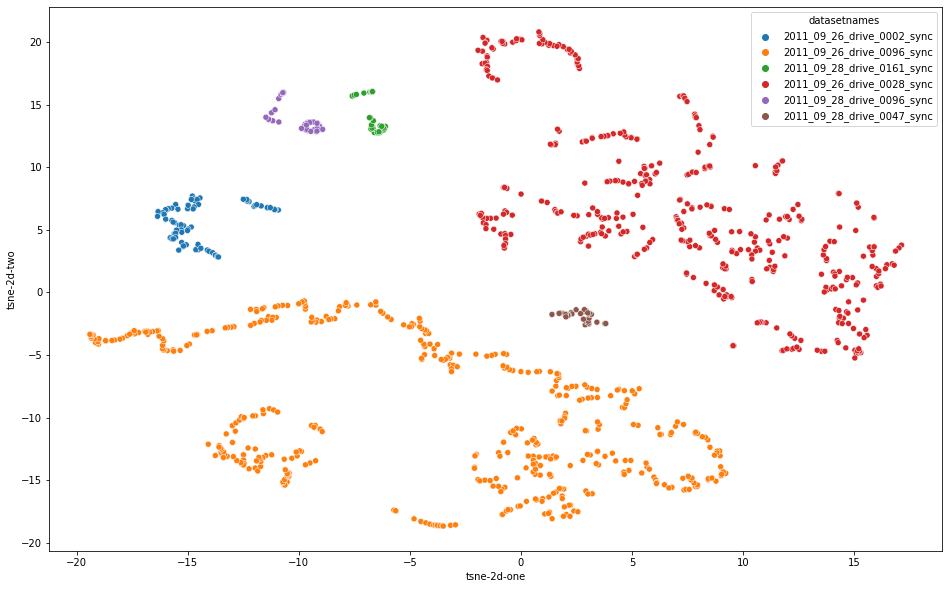

In [5]:
# Create the Plot with t-SNE. We can now clearly distinct different clusters by optical inspection
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['datasetnames'] = datasetnames
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#    color='black',
    hue="datasetnames",
#    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=1.0
)